# IMPORT LIBARIES

https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [69]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import classification_report


# LOAD DATA

In [11]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [12]:
train.head(3)

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive


In [13]:
test.head(3)

,test_idx,text
0,0,fm receiver it has none
1,1,"the picture quality surprised me , when i firs..."
2,2,great video clip quality for a digital camera ...


In [14]:
# check if any colulumn has null values
train.isnull().sum()

train_idx     0
text          0
label         0
label_text    0
dtype: int64

In [15]:
test.isnull().sum()

test_idx    0
text        0
dtype: int64

In [16]:
train["label"].value_counts()

1    1926
0    1090
Name: label, dtype: int64

<Axes: >

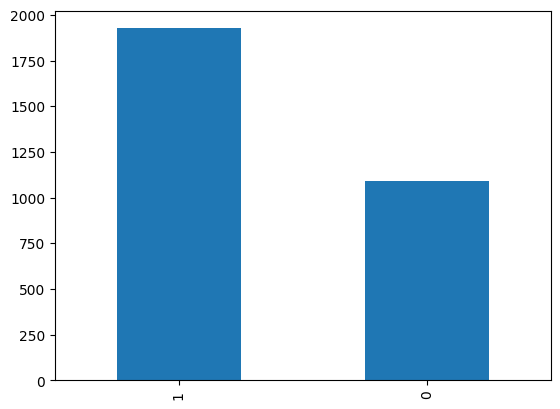

In [17]:
train["label"].value_counts().plot(kind='bar')

In [21]:
# split the train data into train and validation
from sklearn.model_selection import train_test_split
train_split, val_split = train_test_split(train, test_size=0.2, random_state=42)

# TEST MODEL

In [18]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
print(test['text'][np.random.randint(0, len(test))], "\n", sentiment_task(test['text'][np.random.randint(0, len(test))]))


a bit disappoint on that ! 
 [{'label': 'positive', 'score': 0.7560573816299438}]


# PARAMETERS

In [19]:
LR = 2e-5
EPOCHS = 1
BATCH_SIZE = 32
#MODEL = "cardiffnlp/twitter-xlm-roberta-base" # use this to finetune the language model
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment" # use this to finetune the sentiment classifier
MAX_TRAINING_EXAMPLES = -1 # set this to -1 if you want to use the whole training set

# Preprocess

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

In [23]:
train_encodings = tokenizer(train_split['text'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_split['text'].tolist(), truncation=True, padding=True)

In [24]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, train_split["text"])
val_dataset = MyDataset(val_encodings, val_split["text"])

# FINE-TUNING

In [64]:
train

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'text', 'labels'],
        num_rows: 3016
    })
})

In [67]:
train = load_dataset('csv', data_files='data/train.csv')
# have in the train DatasetDict only the columns "train_idx", "text" and "label"
train = train.remove_columns("label_text")
train = train.rename_column("train_idx", "input_ids") # rename the "train_idx" column back to "input_ids" for compatibility with the model
train = train.rename_column("label", "labels") # rename the "label" column back to "labels" for compatibility with the model


# Tokenize your dataset
tokenized_dataset = tokenizer(
    list(train["train"]["text"]),
    truncation=True,
    padding=True,
    max_length=128,
)
# Add labels to the tokenized dataset
tokenized_dataset["labels"] = list(train["train"]["labels"])
# input_ids: this colum contains the tokenized input sequences converted into their corresponding numerical IDs.
# labels: this column contains the target labelsthat you want your model to predict for each input sequence.
# attention_mark: this column contains the attention mask that you will use to tell the model which tokens are actual words and which are padding tokens.

Found cached dataset csv (/home/22021108Cristina/.cache/huggingface/datasets/csv/default-7e50772f604fcc87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
print(tokenized_dataset["attention_mask"][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [74]:
print(tokenized_dataset.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [76]:
print(len(tokenized_dataset["input_ids"]))
print(len(tokenized_dataset["attention_mask"]))

3016
3016


In [88]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load the pre-trained model and tokenizer
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)

# Load the train dataset
train = load_dataset('csv', data_files='data/train.csv', split='train')

# Tokenize the input text
tokenized_dataset = tokenizer(
    list(train['text']),
    truncation=True,
    padding=True,
    max_length=128,
    return_attention_mask=True,
    return_tensors='pt'
)

# Add labels to the tokenized dataset
labels = [int(l) for l in train['label']]
tokenized_dataset['label'] = labels

# Train the model on the tokenized dataset
training_args = TrainingArguments(
    output_dir='./models/2.twitter-xml-roberta-base/',          # output directory
    evaluation_strategy = "epoch",   # evaluate model after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset
)

trainer.train()


Found cached dataset csv (/home/22021108Cristina/.cache/huggingface/datasets/csv/default-7e50772f604fcc87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
/home/22021108Cristina/.local/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


ValueError: The batch received was empty, your model won't be able to train on it. Double-check that your training dataset contains keys expected by the model: input_ids,attention_mask,token_type_ids,position_ids,head_mask,inputs_embeds,labels,output_attentions,output_hidden_states,return_dict,label_ids,labels,label.

In [91]:
tokenized_dataset.keys()

dict_keys(['input_ids', 'attention_mask', 'label'])

In [95]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# Load the pre-trained model and tokenizer
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load dataset
train_dataset = load_dataset('csv', data_files='data/train.csv')['train']

# Tokenize your dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))

# Train the model on your dataset
training_args = TrainingArguments(
    "my_finetuned_model",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()


Found cached dataset csv (/home/22021108Cristina/.cache/huggingface/datasets/csv/default-7e50772f604fcc87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/3016 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


ValueError: Trainer: evaluation requires an eval_dataset.

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
import torch

# Load the tokenizer and the model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

# Load the datasets
train_dataset = torch.load("train_dataset.pt")
eval_dataset = torch.load("eval_dataset.pt")

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    save_total_limit=3,
    save_steps=500,
    learning_rate=5e-5,
    fp16=True
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Start training
trainer.train()

# Evaluate the model
trainer.evaluate()


# Evaluate

In [52]:
accuracy = evaluate.load("accuracy")

In [53]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [54]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# MODEL

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name)#, num_labels=2, id2label=id2label, label2id=label2id)


In [64]:
encoded_train = tokenizer(tokenized_train["train"]["text"], return_tensors="pt")
output_train = model(**encoded_train)
scores = output_train.logits

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).